#### Proyecto

Te han ofrecido hacer prácticas en el departamento de analítica de Showz, una empresa de venta de entradas de eventos. Tu primera tarea es ayudar a optimizar los gastos de marketing. 

Cuentas con:

registros del servidor con datos sobre las visitas a Showz desde enero de 2017 hasta diciembre de 2018;
un archivo con los pedidos en este periodo;
estadísticas de gastos de marketing.
Lo que vas a investigar: 

cómo los clientes usan el servicio;
cuándo empiezan a comprar;
cuánto dinero aporta cada cliente a la compañía;
cuándo los ingresos cubren el costo de adquisición de los clientes.

¿Cuándo empieza la gente a comprar? (En el análisis de KPI, generalmente nos interesa saber el tiempo que transcurre entre el registro y la conversión, es decir, cuando el usuario se convierte en cliente. Por ejemplo, si el registro y la primera compra ocurren el mismo día, el usuario podría caer en la categoría Conversion 0d. Si la primera compra ocurre al día siguiente, será Conversion 1d. Puedes usar cualquier enfoque que te permita comparar las conversiones de diferentes cohortes para que puedas determinar qué cohorte o canal de marketing es más efectivo.)

¿Cuántos pedidos hacen durante un período de tiempo dado?

¿Cuál es el tamaño promedio de compra?

¿Cuánto dinero traen? (LTV)

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns

### Paso 1. Acceda a los datos y prepararlos para el analisis

In [ ]:
# Cargar los csv correspondientes
visits = pd.read_csv('visits_log_us.csv')
orders = pd.read_csv('orders_log_us.csv')
costs = pd.read_csv('costs_us.csv')

##### verificar y limpiar datos.

In [3]:
print(f' Total de datos duplicados: {visits.duplicated().sum()}')
print(f' Total de datos nulos: \n{visits.isnull().sum()}')

#Limpiar encabezados
new_columns_name = []

for row in visits.columns:
    new_name = row.lower().strip().replace(' ','_')
    new_columns_name.append(new_name)

visits.columns = new_columns_name

# Cambiar datos a Dtype correcto
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

visits.info()
visits.head()

 Total de datos duplicados: 0
 Total de datos nulos: 
Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
print(f' Total de datos duplicados: {orders.duplicated().sum()}')
print(f' Total de datos nulos: \n{orders.isnull().sum()}')

#Limpiar encabezados
new_columns_name = []

for row in orders.columns:
    new_name = row.lower().strip().replace(' ','_')
    new_columns_name.append(new_name)

orders.columns = new_columns_name

# Cambiar datos a Dtype correcto
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

orders.info()
orders.head()

 Total de datos duplicados: 0
 Total de datos nulos: 
Buy Ts     0
Revenue    0
Uid        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [5]:
print(f' Total de datos duplicados: {costs.duplicated().sum()}')
print(f' Total de datos nulos: \n{costs.isnull().sum()}')


# Cambiar datos a Dtype correcto
costs['dt'] = pd.to_datetime(costs['dt'])

costs.info()
costs.head()

 Total de datos duplicados: 0
 Total de datos nulos: 
source_id    0
dt           0
costs        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


##### 
Como se puede observar habia que trabajar los datos antes de procesarlos, si bien no contamos con datos duplicados o nulos si se ve apropiado ajustar nombres de columnas y cambiar los tipos de datos como los de las fechas a razon de poder procesar y trabajar los datos de la mejor manera posible.

### Paso 2. Realizar informes y calcular metricas

####   2.1 Visitas:
2.1.1 ¿Cuántas personas lo usan cada día, semana y mes?

In [6]:
# ¿Cuántas personas lo usan cada día, semana y mes?

visits['month']= visits['start_ts'].dt.to_period('M').dt.start_time
visits['week']= visits['start_ts'].dt.isocalendar().week
visits['date']= visits['start_ts'].dt.date

mau_total = visits.groupby('month',).agg({'uid':'nunique'}).mean()
wau_total = visits.groupby('week',).agg({'uid':'nunique'}).mean()
dau_total = visits.groupby('date',).agg({'uid':'nunique'}).mean()

print(f'Total de usuarios por mes: {int(mau_total.iloc[0])}')
print(f'Total de usuarios por semana: {wau_total}')
print(f'Total de usuarios por dia: {dau_total}')

Total de usuarios por mes: 23228
Total de usuarios por semana: uid    5825.288462
dtype: float64
Total de usuarios por dia: uid    907.991758
dtype: float64


#### 2.1.2 ¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión)

In [7]:
# ¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión).

sessions_per_user = visits.groupby('date').agg({'uid':['count','nunique']})
sessions_per_user.columns = ['n_sessions','n_users']
sessions_per_user['session_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
print(f'En promedio los usuarios inician sesion un total de {sessions_per_user['session_per_user'].mean():.2f} veces')

En promedio los usuarios inician sesion un total de 1.08 veces


### 2.1.3 ¿Cuál es la duración de cada sesión?

0    60
Name: duration, dtype: int32
La duracion promedio de cada sesion es de 60 segundos


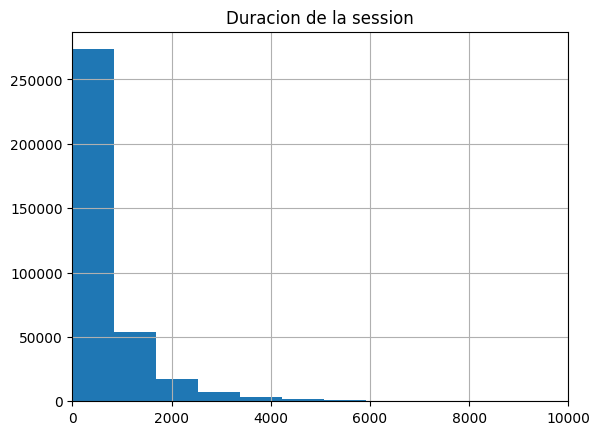

In [8]:
visits['duration'] = (visits['end_ts']- visits['start_ts']).dt.seconds
asl = visits['duration'].mode()
print(asl)
print( 'La duracion promedio de cada sesion es de 60 segundos')
visits['duration'].hist(bins=100).set(title='Duracion de la session')
plt.xlim(0,10000)
plt.show()

##### 2.1.4 ¿Con qué frecuencia los usuarios regresan?

In [9]:
# Encontrar la primera actividad del usuario
first_activity_date = visits.groupby('uid')['start_ts'].min().reset_index()
first_activity_date.columns = ['uid','first_activity']

# Sesiones mensuales 
first_activity_date['first_activity_date']= pd.to_datetime(first_activity_date['first_activity'].dt.date)
first_activity_date['first_activity_month']= first_activity_date['first_activity'].dt.to_period('M').dt.start_time

#unir los dataframes
visits_completed = visits.merge(first_activity_date, on='uid')

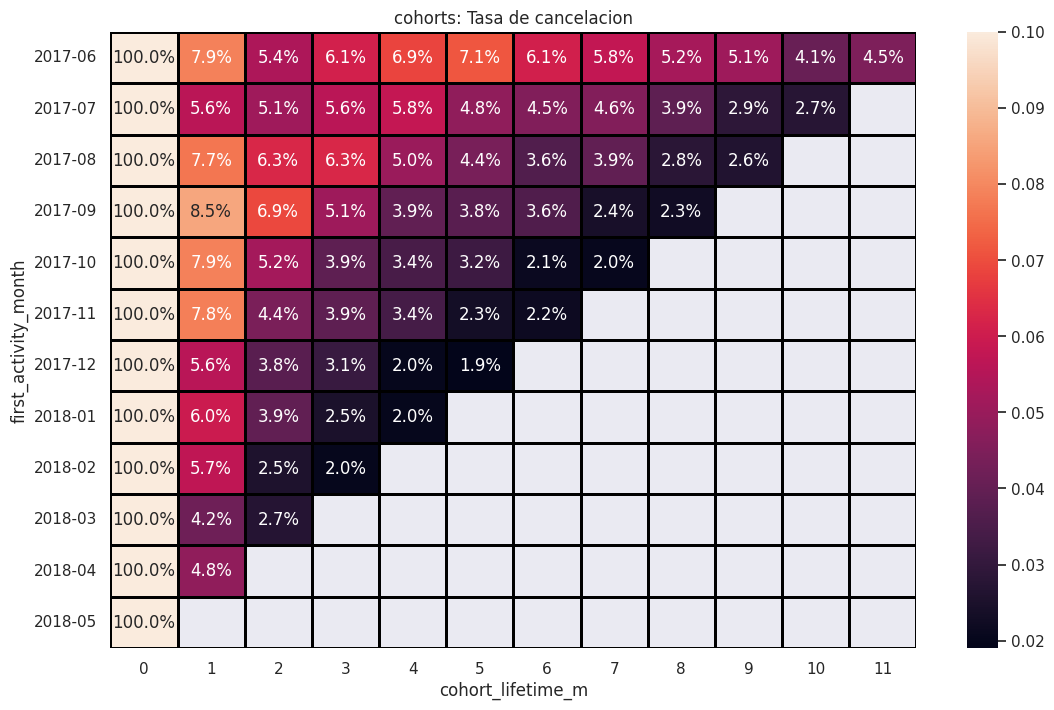

In [10]:
# Calcular ciclo de vida

visits_completed['cohort_lifetime_m']= (visits_completed['month'].dt.month -visits_completed['first_activity_month'].dt.month)
# Se agrega la siguiente operacion para calcular los years
visits_completed['cohort_lifetime_m']+= 12*(visits_completed['month'].dt.year- visits_completed['first_activity_month'].dt.year)


# Agrupamos para crear un nuevo df
cohorts= visits_completed.groupby(['first_activity_month','cohort_lifetime_m']).agg({'uid':'nunique'}).reset_index()

# Vamos a buscar el numero inicial de usuarios en la cohorte observando la semana 0 
initial_user_count= cohorts[cohorts['cohort_lifetime_m']== 0][['first_activity_month','uid']]

# Renombramos la columna
initial_user_count= initial_user_count.rename(columns={'uid':'cohort_users'})

# Unimos las dos tablas con merge 
cohorts= cohorts.merge(initial_user_count, on='first_activity_month')


# Calculamos la tasa de retencion
cohorts['retention']= cohorts['uid']/cohorts['cohort_users']

#Se ajustan fechas para la grafica
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m')
# Creamo nuestra pivot
retention_pivot= cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime_m',
    values='retention',
    aggfunc='sum'
)
#retention_pivot= retention_pivot.fillna('')

sns.set(style='dark')
plt.figure(figsize=(13,8))
plt.title('cohorts: Tasa de cancelacion')
sns.heatmap(retention_pivot, annot=True,fmt='.1%',linewidths=1,linecolor='black',vmax=0.1)
plt.show()

In [11]:
# Calculamos el Sticky factor (la metrica nos indica con que frecuencia regresan a la aplicacion)
sticky_mau = (dau_total/mau_total)*100
sticky_wau = (dau_total/wau_total)*100

print(sticky_mau)
print(sticky_wau)

uid    3.90897
dtype: float64
uid    15.587069
dtype: float64


##### El numero semanal es mucho mas alto que el mensual, lo que sugiere que hay un alto nivel de engagement en el corto plazo, pero posiblemente disminuye con el tiempo, algo similar se puede ver con la tasa de retencion, despues del primer mes son muy pocas las personas que se mantienen. 

#### 2.2 Ventas


##### 2.2.1 ¿Cuándo empieza la gente a comprar?

In [12]:
# Agregamos dia y mes
orders['order_date'] = orders['buy_ts'].dt.date
orders['order_month']= orders['buy_ts'].dt.to_period('M')

In [13]:
# Encontrar primeras ordenes
first_order= orders.groupby('uid')['buy_ts'].min().reset_index()
first_order.columns= ['uid','first_order_ts']
first_order['first_order_dt']= first_order['first_order_ts'].dt.date
first_order['first_order_month'] =  first_order['first_order_ts'].dt.to_period('M')


# unimos los datasets
buyers = orders.merge(first_order, on='uid')
buyers = buyers.merge(visits_completed, on='uid')
buyers.head()
buyers['first_order_dt']= pd.to_datetime(buyers['first_order_dt'])
buyers['order_date']= pd.to_datetime(buyers['order_date'])


0    4
Name: days_to_first_purchase, dtype: int64
El tiempo promedio desde el inicio de sesion a la primera compra es de 4 dias


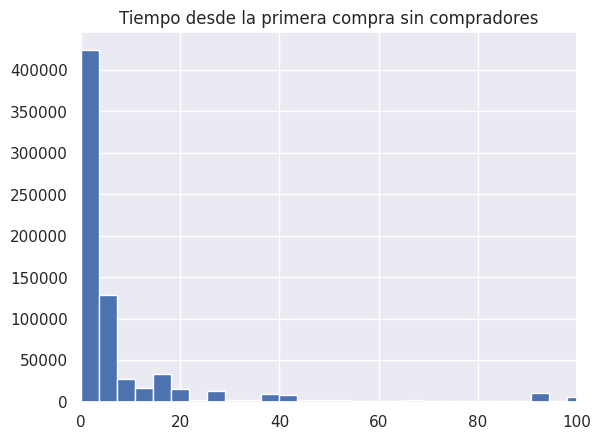

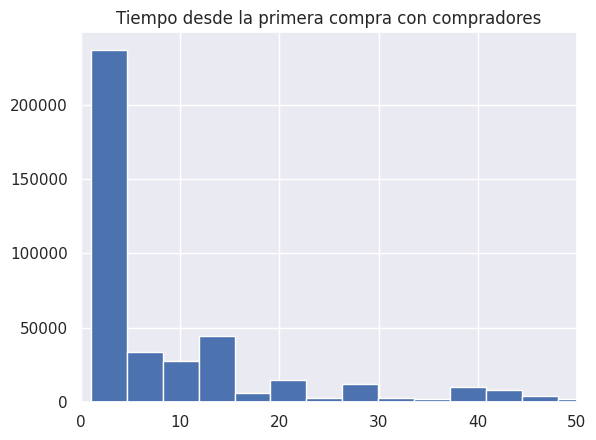

In [14]:
# Calcular cuando compra la gente

buyers['days_to_first_purchase']= (buyers['first_order_dt']- buyers['first_activity_date'])
buyers['days_to_first_purchase']= (buyers['days_to_first_purchase']/np.timedelta64(1,'D')).astype(int)

buyers_filtered= buyers[buyers['days_to_first_purchase'] != 0]

days_to_first_purchase = buyers_filtered['days_to_first_purchase'].mode()
print(days_to_first_purchase)
print( 'El tiempo promedio desde el inicio de sesion a la primera compra es de 4 dias')

# Graficamos 
buyers['days_to_first_purchase'].hist(bins=100).set(title='Tiempo desde la primera compra sin compradores')
plt.xlim(0,100)
plt.show()

buyers_filtered['days_to_first_purchase'].hist(bins=100).set(title='Tiempo desde la primera compra con compradores')
plt.xlim(0,50)
plt.show()


##### La gente empieza a comprar despues del cuarto dia o al menos es el dato que mas se repite, eso si tenemos en cuenta que omitimos a las personas que no compraron si analizamos con los no compradores podemos ver que hay muchas personas que navegan pero que no realizan ninguna compra.  

##### 2.2.2 ¿Cuántos pedidos hacen durante un período de tiempo dado?

In [15]:
buyers_group =buyers.groupby(['first_order_month','order_month']).agg({'uid':'count'})

pivot_table = buyers_group.pivot_table(
    index='first_order_month',
    columns='order_month',
    values='uid',
    aggfunc='sum')# si ajusto a mean no deberia cambiar , revisar 

pivot_table.fillna('')

order_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
first_order_month,,,,,,,,,,,,,
2017-06,25839.0,25677.0,25127.0,38866.0,44356.0,32355.0,48849.0,30756.0,41971.0,28912.0,16641.0,9514.0,
2017-07,,8692.0,4006.0,8680.0,4384.0,2656.0,6872.0,4071.0,1825.0,1643.0,1076.0,4125.0,
2017-08,,,6713.0,5353.0,5268.0,4705.0,6555.0,3866.0,2976.0,4794.0,3187.0,1961.0,
2017-09,,,,12257.0,5096.0,4513.0,7011.0,2673.0,4295.0,5064.0,2409.0,2131.0,
2017-10,,,,,14519.0,3645.0,1844.0,1470.0,1889.0,1563.0,2030.0,3093.0,
2017-11,,,,,,20250.0,12264.0,5359.0,9642.0,4811.0,1113.0,3976.0,
2017-12,,,,,,,17919.0,7840.0,7952.0,5552.0,2701.0,2908.0,
2018-01,,,,,,,,13679.0,8337.0,5162.0,2127.0,3088.0,
2018-02,,,,,,,,,12415.0,5550.0,2334.0,2219.0,


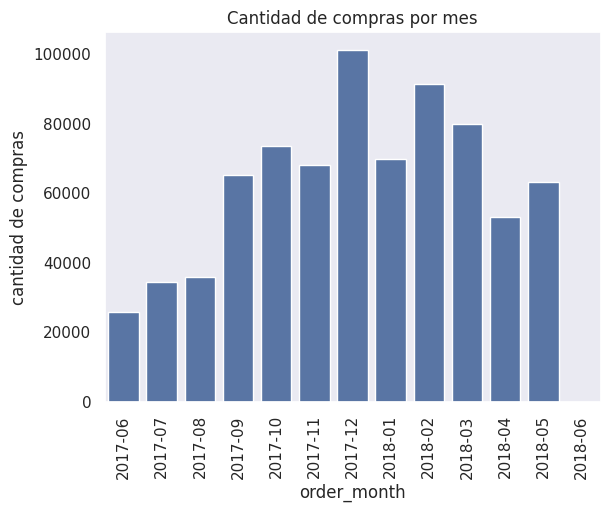

In [16]:
buyers_group =buyers.groupby('order_month').agg({'uid':'count'})
sns.barplot(data=buyers_group,
            x='order_month',
            y='uid')
plt.ylabel('cantidad de compras')
plt.xticks(rotation=90)
plt.title('Cantidad de compras por mes')
plt.show()

##### Aca podemos observar la cantidad de pedidos que se hacen durante un mes y tambien se puede ver cantidad de pedidos que hacen por cohortes

##### 2.2.3 ¿Cuál es el tamaño promedio de compra?

In [17]:
buyers_group =buyers.groupby('order_month').agg({'revenue':'mean'}).reset_index()
print(f'El tamano promedio de compra es de {buyers_group['revenue'].mean()}')
buyers_group

El tamano promedio de compra es de 8.219474156140892


,order_month,revenue
0,2017-06,5.732470
1,2017-07,7.390010
2,2017-08,5.901971
3,2017-09,11.334179
4,2017-10,9.337978
5,2017-11,7.310166
6,2017-12,14.263328
7,2018-01,7.234294
8,2018-02,7.311842
9,2018-03,10.187199


##### 2.2.4¿Cuánto dinero traen? (LTV)

In [18]:
# Como no tenemos el margen podemos deducirlo segun las ganancias y los costos que tenemos
ingresos = buyers.groupby('order_month').agg({'revenue':'sum'}).reset_index()
ingresos.columns=['month','revenue']
costs['month']= costs['dt'].dt.to_period('M')
costos= costs.groupby('month')['costs'].sum().reset_index()
cos_rev= pd.merge(ingresos,costos, on='month')
cos_rev['margin'] =  (cos_rev['revenue']- cos_rev['costs'])/ cos_rev['revenue']
print(cos_rev['margin'].mean())

0.9418882368396067


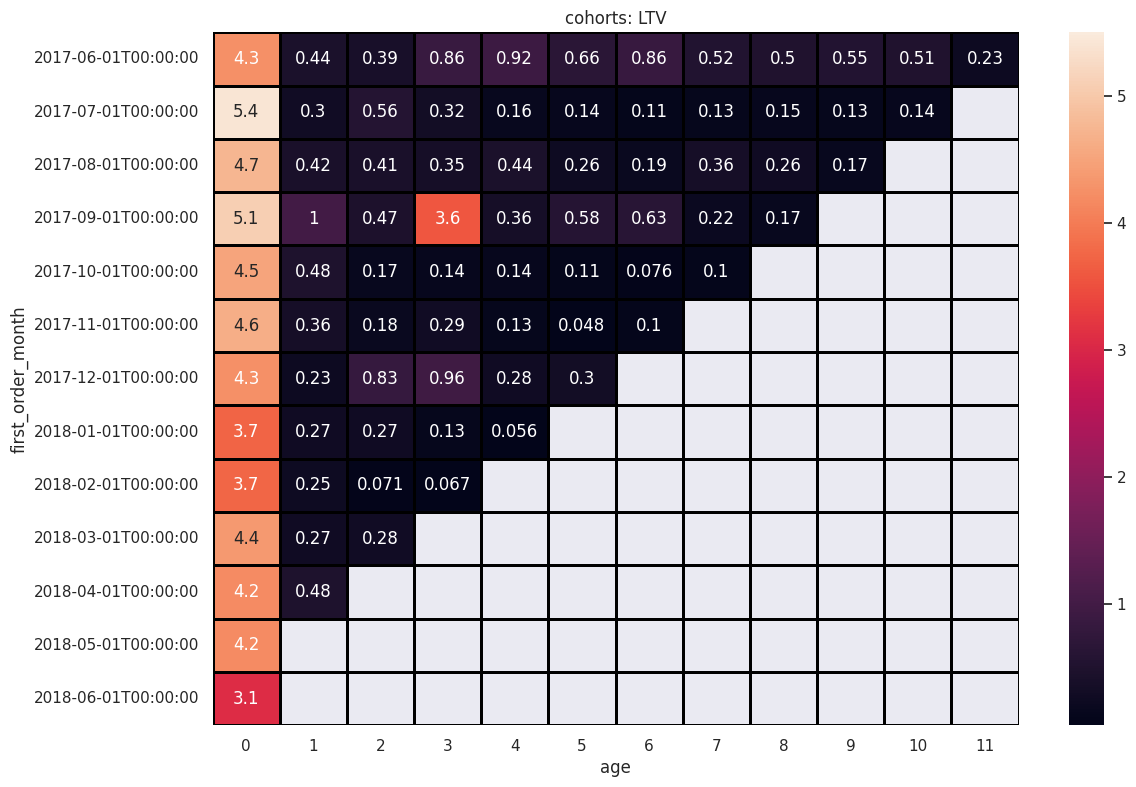

In [19]:
# procedemos a realizar los ajustes necesarios para calcular el LTV
orders['order_date'] = pd.to_datetime(orders['buy_ts'])
costs['date']= pd.to_datetime(costs['dt'])

orders['order_month']= orders['order_date'].values.astype('datetime64[M]')
costs['month']= costs['date'].values.astype('datetime64[M]')

firsts_orders= orders.groupby('uid')['order_month'].min().reset_index()
firsts_orders.columns= ['uid','first_order_month']

cohorts_sizes= firsts_orders.groupby('first_order_month')['uid'].nunique().reset_index()
cohorts_sizes.columns=['first_order_month','n_buyers']

# Usamos el margin rate calculado aproximado arriba ((revenue - costos)/ revenue) dado que no contamos con la informacion
margin_rate = 0.9

orders_ = pd.merge(orders,firsts_orders, on='uid')

cohorts= orders_.groupby(['first_order_month','order_month']).agg({'revenue':'sum'}).reset_index()

report= pd.merge(cohorts_sizes, cohorts, on='first_order_month')

report['gp']= report['revenue']* margin_rate

report['age'] = (
    (report['order_month'].dt.year - report['first_order_month'].dt.year) * 12 + 
    (report['order_month'].dt.month - report['first_order_month'].dt.month)
)

report['ltv']= report['gp']/report['n_buyers']

result= report.pivot_table(
    index='first_order_month',
    columns='age',
    values='ltv',
    aggfunc='mean'
)
sns.set(style='dark')
plt.figure(figsize=(13,9))
plt.title('cohorts: LTV')
sns.heatmap(result, annot=True,linewidths=1,linecolor='black',vmax=5.5)
plt.show()

In [20]:
# calculamos el ltv por mes
ltv_by_month= report.groupby('first_order_month')['ltv'].sum().reset_index()

print(f'En promedio cada cliente dejo {ltv_by_month['ltv'].mean():.2f} dolares en ingresos')

ltv_by_month

En promedio cada cliente dejo 6.29 dolares en ingresos


,first_order_month,ltv
0,2017-06-01,10.691310
1,2017-07-01,7.548168
2,2017-08-01,7.624550
3,2017-09-01,12.091704
4,2017-10-01,5.724218
5,2017-11-01,5.755719
6,2017-12-01,6.875922
7,2018-01-01,4.446136
8,2018-02-01,4.129129
9,2018-03-01,4.909728


#### 2.3 Marketing

#####  2.3.1. ¿Cuánto dinero se gastó?  (Total/por fuente de adquisición/a lo largo del tiempo) 

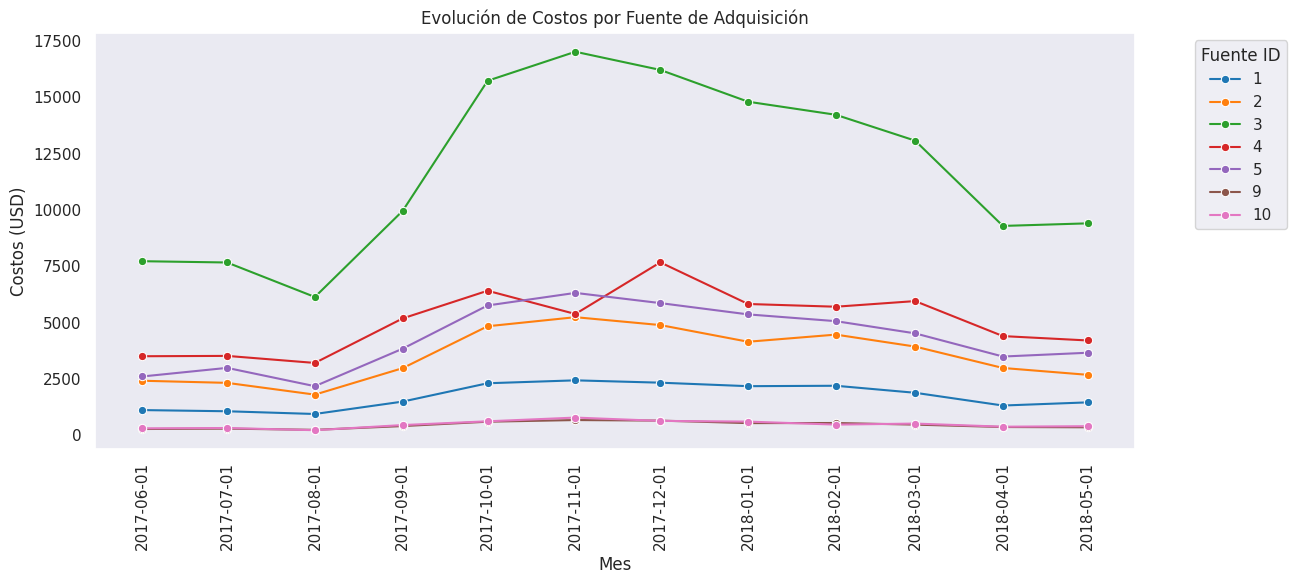

In [21]:
monthly_cost_by_source= costs.groupby(['month','source_id'])['costs'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_cost_by_source, x='month', y='costs', hue='source_id', 
             palette='tab10', marker='o')
plt.title('Evolución de Costos por Fuente de Adquisición')
plt.xlabel('Mes')
plt.ylabel('Costos (USD)')
plt.xticks(ticks=monthly_cost_by_source['month'].unique(),
    rotation=90)
plt.legend(title='Fuente ID', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

#####  2.3.2 ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?

In [22]:
monthly_cost_by_source

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


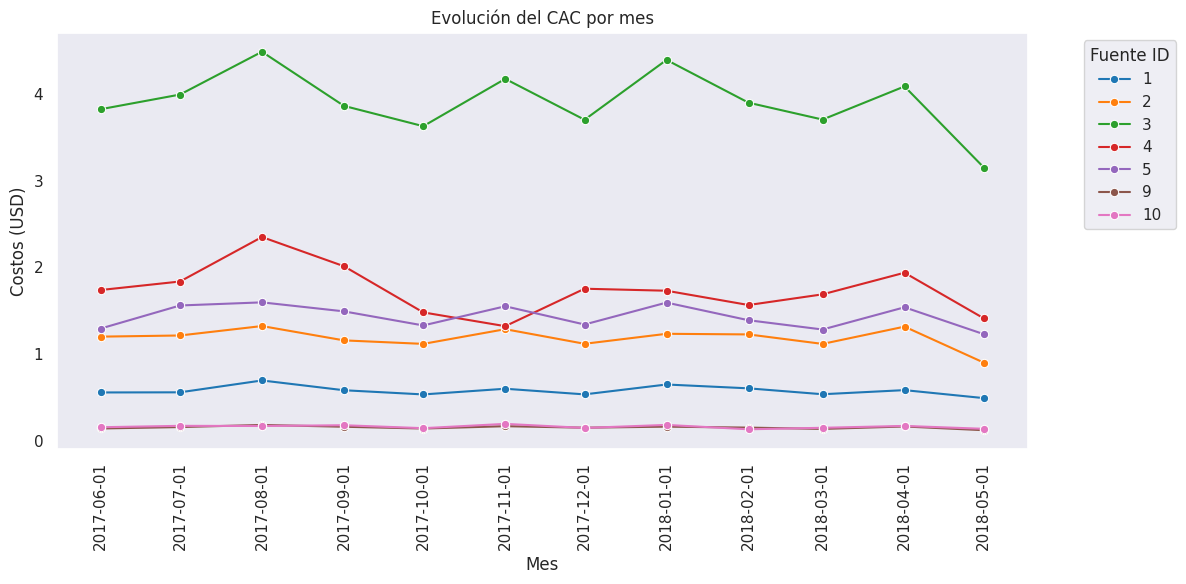

En promedio cada cliente costo 1.31 dolares en ingresos


In [23]:

report_= pd.merge(report,monthly_cost_by_source,left_on='first_order_month', right_on='month')

report_['cac']= (report_['costs']/ report_['n_buyers'])
report_
cac_by_month_source = report_.groupby(['first_order_month','source_id'])['cac'].mean().reset_index()
#cac_mes_fuente = merged_df.groupby(['first_order_month', 'source_id'])['cac'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.lineplot(data=cac_by_month_source, x='first_order_month', y='cac', hue='source_id', 
             palette='tab10', marker='o')
plt.title('Evolución del CAC por mes')
plt.xlabel('Mes')
plt.ylabel('Costos (USD)')
plt.xticks(ticks=cac_by_month_source['first_order_month'].unique(),
    rotation=90)
plt.legend(title='Fuente ID', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

print(f'En promedio cada cliente costo {cac_by_month_source['cac'].mean():.2f} dolares en ingresos')

#### 2.3.3. ¿Cuán rentables eran las inversiones? (ROMI)

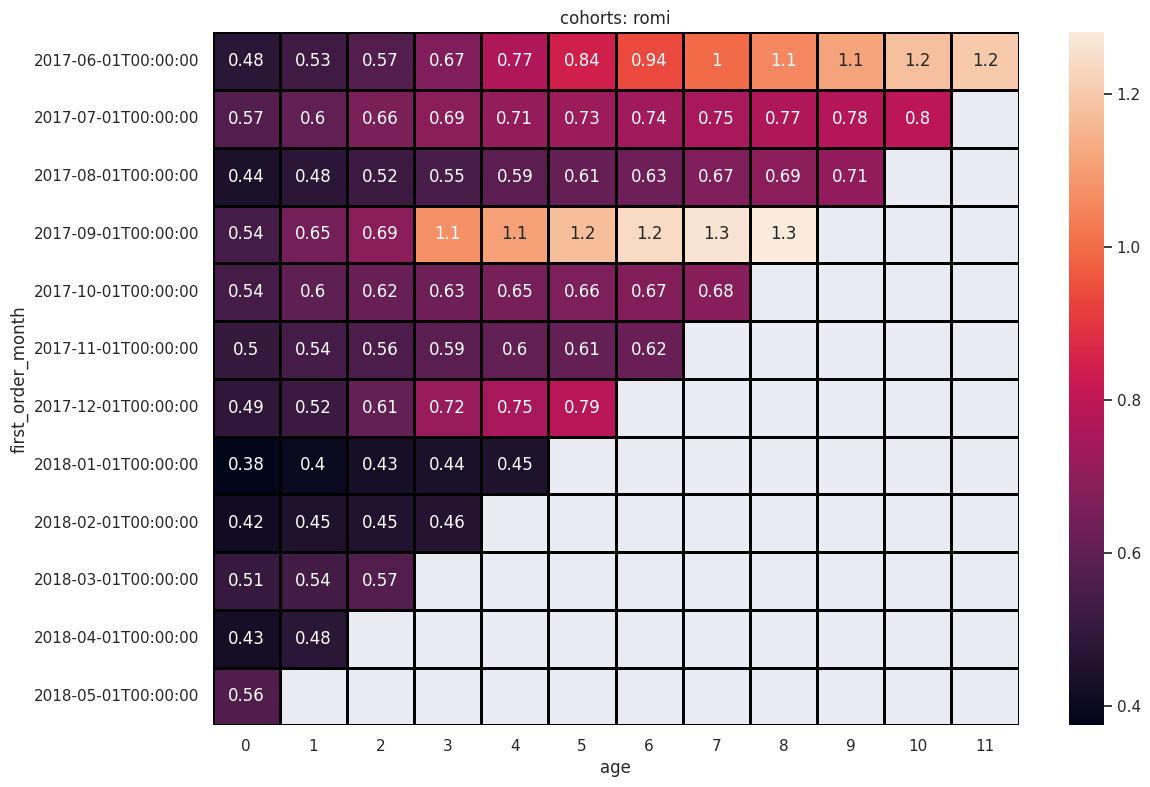

In [24]:
monthly_cost= costs.groupby('month')['costs'].sum().reset_index()

report_2= pd.merge(report,monthly_cost,left_on='first_order_month', right_on='month')

report_2['cac']= report_2['costs']/ report_2['n_buyers']
report_2

report_2['romi']= report_2['ltv']/ report_2['cac']

output= report_2.pivot_table(
    index='first_order_month',
    columns='age',
    values='romi',
    aggfunc='mean'
)
#print(output.cumsum(axis=1).round(2).fillna(''))

sns.set(style='dark')
plt.figure(figsize=(13,9))
plt.title('cohorts: romi')
sns.heatmap(output.cumsum(axis=1).round(3), annot=True,linewidths=1,linecolor='black')
plt.show()

In [25]:
romi_month= output.cumsum(axis=1).mean(axis=0).reset_index()
romi_month.columns=['age','romi_cum']
romi_month

,age,romi_cum
0,0,0.486734
1,1,0.523786
2,2,0.567962
3,3,0.647766
4,4,0.704652
5,5,0.773888
6,6,0.807137
7,7,0.872956
8,8,0.948484
9,9,0.868039


#### 3. Escribe una conclusión:

¿Qué fuentes/plataformas recomendarías?  Fundamenta tu selección: ¿en qué métricas te enfocaste?  ¿Por qué? ¿Qué conclusiones sacaste después de encontrar los valores métricos?
Como se puede obersar a lo largo del analisis pudimos observar que los usuarios acceden a la plataforma pero despues de la primera compra se pierden muchos clientes, se deberian enfocar esfuerzos para mantener un porcentaje mas alto de clientes o de plano investigar cual es la causa de la alta decersion.

Tambien se aconseja usar o invertir mas en las otras fuentes de anuncion ademas de la numero tres esto debido a que es la que mas le cuesta a la empresa en coste de adqusiion por cliente, las otras parecen mas rentables.

Si bien el romi en alguas cohortes alcanzo el retorno de inversion en algunos meses en general o en promedio nos indica que tarda casi 12 meses en pasar el punto de equilibrio, su crecimiento no es lineal lo que podria explicarse en los aumentos en los costos de marketing durante algunos periodos de tiempo. 